# WebRender dashboard ETL script

You probably want to look at the [published dashboard](file:///Users/tsmith/projects/webrender-dashboard/dashboard.html).

You can check [scheduled run status](https://dbc-caf9527b-e073.cloud.databricks.com/#job/715).


### What's different?

* Metrics are summarized by build (vs date).
* Performance metrics are aggregated over users; this is important because it reduces the impacts of outlier users on our understanding of product performance, and because it reflects how WebRender changes the user experience at the user level.
* Pings are artisanally hand-selected so that comparisons between experiment branches are fair even in the presence of the various enrollment weirdnesses.

In [2]:
%r
library(boot)
library(dplyr, warn.conflicts=FALSE)
library(ggplot2)
library(sparklyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)

sc = spark_connect(method="databricks")

# Save result tables so we can access them from hala
final_outdb_path = "/dbfs/tdsmith/webrender.sqlite3"

In [3]:
from moztelemetry.dataset import Dataset
import pandas as pd
from pyspark.sql import Row
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, BooleanType, IntegerType, DoubleType, LongType, MapType
from statsmodels.stats.weightstats import DescrStatsW

EXPERIMENT_ID = "prefflip-webrender-v1-2-1492568"
EXPERIMENT_ID_2 = "prefflip-webrender-v1-3-1492568"
PARTITIONS = [s.replace("-", "_") for s in (EXPERIMENT_ID, EXPERIMENT_ID_2)]

In [4]:
to_summarize = {
  "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
  "content_frame_time": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME",
  "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
  "tab_switch_composite": "payload.histograms.FX_TAB_SWITCH_COMPOSITE_E10S_MS",
  "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
  "page_load_ms": "payload.histograms.FX_PAGE_LOAD_MS_2"
}

to_pull = {}
for k, v in to_summarize.items():
  to_pull[k] = v + ".values"
  to_pull[k + "_sum"] = v + ".sum"

pings = (
  Dataset
  .from_source("telemetry-cohorts")
  .where(
    docType="main",
    experimentId=lambda x: x in PARTITIONS,
  )
  .select(
    app_build_id="application.buildId",
    branch='environment.experiments."%s".branch' % EXPERIMENT_ID,
    branch2='environment.experiments."%s".branch' % EXPERIMENT_ID_2,
    client_id="clientId",
    gfx_compositor="environment.system.gfx.features.compositor",
    normalized_channel="meta.normalizedChannel",
    profile_subsession_counter="payload.info.profileSubsessionCounter",
    session_id="payload.info.sessionId",
    target_pref_value='environment.settings.userPrefs."gfx.webrender.all.qualified"',
    # ---
    device_reset_reason_content="payload.processes.content.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_gpu="payload.processes.gpu.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_parent="payload.histograms.DEVICE_RESET_REASON.values",
    subsession_length="payload.info.subsessionLength",
    active_ticks='payload.processes.parent.scalars."browser.engagement.active_ticks"',
    total_uris='payload.processes.parent.scalars."browser.engagement.total_uri_count"',
    **to_pull
  )
  .records(sc)
)

def ping_to_row(x):
  for k, v in to_summarize.items():
    x[k + "_count"] = sum((x[k] or {}).values())
  
  x["experiment"] = (x["branch"] and 2) or 3
  x["branch"] = x["branch"] or x["branch2"]
  del x["branch2"]
  
  # Aggregate DEVICE_RESET_REASON for crash rates
  procs = ("parent", "content", "gpu")
  x["device_reset_reason_total"] = 0
  for proc in procs:
    key = "device_reset_reason_" + proc
    x[key + "_count"] = sum((x[key] or {}).values())
    x["device_reset_reason_total"] += x[key + "_count"]
    del x[key]
  
  # Calculate usage hours for crash rates
  # Based on https://github.com/mozilla/telemetry-streaming/blob/ee2eafd18a8b12a3fafca496d58789f641069bf6/src/main/scala/com/mozilla/telemetry/pings/MainPing.scala#L71-L82
  subsession_length = x["subsession_length"] or 0
  x["usage_hours"] = max(min(subsession_length/3600., 25.), 0.)
  return Row(**x)

fetching 156073.35638MB in 65380 files...

In [5]:
sdf_fields = [
  StructField("app_build_id", StringType(), True),
  StructField("branch", StringType(), False),
  StructField("client_id", StringType(), False),
  StructField("experiment", IntegerType(), False),
  StructField("gfx_compositor", StringType(), True),
  StructField("normalized_channel", StringType(), True),
  StructField("profile_subsession_counter", LongType(), True),  
  StructField("session_id", StringType(), True),
  StructField("target_pref_value", BooleanType(), True),
  StructField("device_reset_reason_parent_count", LongType(), True),
  StructField("device_reset_reason_content_count", LongType(), True),
  StructField("device_reset_reason_gpu_count", LongType(), True),
  StructField("device_reset_reason_total", LongType(), True),
  StructField("active_ticks", LongType(), True),
  StructField("total_uris", LongType(), True),
  StructField("subsession_length", LongType(), True),
  StructField("usage_hours", DoubleType(), True),
]

for k, v in to_summarize.items():
  sdf_fields.extend([
    StructField(k, MapType(StringType(), LongType()), True),
    StructField(k + "_sum", LongType(), True),
    StructField(k + "_count", LongType(), True),
  ])

sdf = spark.createDataFrame(pings.map(ping_to_row), schema=StructType(sdf_fields))

In [6]:
sdf.cache()
None

In [7]:
# Because compositor changes don't take effect until the browser restarts,
# we should discard the enrollment session we observe for each client.
# We'll find those sessions here, and then anti-join against this table later.

first_sessions = (
  sdf
  .orderBy(sdf.experiment, sdf.client_id, sdf.branch, sdf.profile_subsession_counter)
  .groupBy(sdf.experiment, sdf.client_id, sdf.branch)
  .agg(
    f.first(sdf.session_id).alias("session_id"),
  )
)

In [8]:
# Broadcast joins time-out unless the cluster is warm
spark.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

subsessions = (
  sdf
  .join(first_sessions, on=["experiment", "client_id", "branch", "session_id"], how="left_anti")
  .where(sdf.target_pref_value.isNotNull())
  .where(
    ((sdf.branch == "disabled") & (sdf.gfx_compositor == "d3d11"))
    | ((sdf.branch == "enabled") & (sdf.gfx_compositor == "webrender"))
  )
  .where(
    (sdf.normalized_channel == "beta") | (sdf.normalized_channel == "nightly")
  )
  .cache()
)

In [9]:
subsessions.createOrReplaceGlobalTempView("webrender_metrics")

In [10]:
# Compute per-user quantiles for CONTENT_PAINT_TIME

def generate_quantile_udf(sdf, grouping_fields, bucket_field, count_field, quantiles):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  quantiles: List of quantiles as floating point values on [0, 1]
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("quantile", DoubleType(), False))
    .add(StructField("value", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    stats = DescrStatsW(df[bucket_field].astype(float), df[count_field]).quantile(quantiles)
    stats = stats.rename_axis("quantile").reset_index(name="value").assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(stats, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

metric_quantiles = generate_quantile_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  quantiles=[0.5, 0.9, 0.95, 0.99]
)

paint_time_quantiles = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_paint_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel, "bucket")
  .agg(f.sum("count").alias("count"))
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(metric_quantiles)
)

paint_time_quantiles.createOrReplaceGlobalTempView("wr_paint_time_quantiles")

In [11]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def generate_threshold_udf(sdf, grouping_fields, bucket_field, count_field, thresholds):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  thresholds: List of thresholds. Should probably align on the left edge of a bucket.
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    rows = []
    all_sum = float(df[count_field].sum())
    for tx in thresholds:
      fraction = df.loc[df[bucket_field].astype(int) >= tx, count_field].sum() / all_sum
      rows.append({"threshold": tx, "fraction_exceeding": fraction})
    data = pd.DataFrame(rows).assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(data, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

vsync_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[250],
)

slow_content_frame_time = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_frame_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)

slow_content_frame_time.createOrReplaceGlobalTempView("wr_slow_content_frame_time")

In [12]:
# Summarize instances of other performance metrics exceeding 16ms

# to_summarize = {
#   "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
#   "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
#   "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
# }

time_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[16],
)

time_threshold_histograms = ["composite_time", "content_paint_time", "content_full_paint_time"]
for h in time_threshold_histograms:
  slow_df = (
    subsessions
    .select(
      subsessions.client_id,
      subsessions.branch,
      subsessions.normalized_channel,
      subsessions.app_build_id,
      f.explode(h).alias("bucket", "count")
    )
    .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
    .apply(time_threshold)
  )
  slow_df.createOrReplaceGlobalTempView("wr_slow_%s" % h)

In [13]:
crash_pings = (
  Dataset
  .from_source("telemetry-cohorts")
  .where(
    docType="crash",
    experimentId=lambda x: x in PARTITIONS,
  )
  .select(
    app_build_id="application.buildId",
    branch='environment.experiments."%s".branch' % EXPERIMENT_ID,
    branch2='environment.experiments."%s".branch' % EXPERIMENT_ID_2,
    client_id="clientId",
    gfx_compositor="environment.system.gfx.features.compositor",
    ipc_channel_error="payload.metadata.ipc_channel_error",
    normalized_channel="meta.normalizedChannel",
    oom_allocation_size="payload.metadata.OOMAllocationSize",
    process="payload.processType",
    session_id="payload.sessionId",
    target_pref_value='environment.settings.userPrefs."gfx.webrender.all.qualified"',
  )
  .records(sc)
)

def crash_ping_to_row(x):
  x["experiment"] = (x["branch"] and 2) or 3
  x["branch"] = x["branch"] or x["branch2"]
  del x["branch2"]
  x["is_shutdown_crash"] = x["ipc_channel_error"] == "ShutDownKill"
  x["is_oom_crash"] = x["oom_allocation_size"] is not None
  return Row(**x)

fetching 432.22216MB in 27357 files...

In [14]:
# Some of these fields are frequently null, so sampling the first 100 rows doesn't work reliably,
# and setting a sampling fraction is slow and still flaky, so declare an explicit schema...
crashes = spark.createDataFrame(crash_pings.map(crash_ping_to_row), StructType([
  StructField("client_id", StringType(), False),
  StructField("experiment", IntegerType(), False),
  StructField("branch", StringType(), False),
  StructField("app_build_id", StringType(), True),
  StructField("session_id", StringType(), True),
  StructField("target_pref_value", StringType(), True),
  StructField("gfx_compositor", StringType(), True),
  StructField("normalized_channel", StringType(), True),
  StructField("process", StringType(), True),
  StructField("ipc_channel_error", StringType(), True),
  StructField("oom_allocation_size", StringType(), True),
  StructField("is_shutdown_crash", BooleanType(), True),
  StructField("is_oom_crash", BooleanType(), True),
]))

In [15]:
# Child process crashes are not labeled with telemetry sessionId's so we can't correctly deplete webrender crashes from the initial session
# https://bugzilla.mozilla.org/show_bug.cgi?id=1502534

valid_crashes = (
  crashes
  .join(first_sessions, on=["experiment", "client_id", "branch", "session_id"], how="left_anti")
  .where(crashes.target_pref_value.isNotNull())
  .where(
    ((crashes.branch == "disabled") & (crashes.gfx_compositor == "d3d11"))
    | ((crashes.branch == "enabled") & (crashes.gfx_compositor == "webrender"))
  )
  .where(
    (crashes.normalized_channel == "beta") | (crashes.normalized_channel == "nightly")
  )
  .cache()
)

In [16]:
usage_per_build = (
  subsessions
  .groupby(subsessions.app_build_id, subsessions.normalized_channel, subsessions.branch)
  .agg(
    f.sum(subsessions.usage_hours).alias("usage_hours"),
    f.sum(subsessions.device_reset_reason_total).alias("device_reset_reason_total"),
  )
)

crashes_per_build = (
  valid_crashes
  .groupby(valid_crashes.app_build_id, valid_crashes.normalized_channel, valid_crashes.branch)
  .agg(
    f.count("*").alias("total_crashes"),
    f.sum(valid_crashes.is_shutdown_crash.cast("integer")).alias("shutdown_crashes"),
    f.sum(valid_crashes.is_oom_crash.cast("integer")).alias("oom_crashes"),
  )
  .join(usage_per_build, on=["app_build_id", "normalized_channel", "branch"])
)

crashes_per_build_per_process = (
  valid_crashes
  .groupby(valid_crashes.app_build_id, valid_crashes.normalized_channel, valid_crashes.branch, valid_crashes.process)
  .agg(
    f.count("*").alias("total_crashes"),
  )
  .join(usage_per_build, on=["app_build_id", "normalized_channel", "branch"])
)

# Use global temp views because Databricks's session isolation support doesn't work for sparklyr
crashes_per_build.createOrReplaceGlobalTempView("wr_crash_summary")
crashes_per_build_per_process.createOrReplaceGlobalTempView("wr_crash_summary_by_process")

## Crash summary

Be skeptical when interpreting crash rates from recent builds. We receive pings that tell us about crashes before we receive pings that tell us about usage, so estimates of crash rates are much higher than the true rate for the first few days builds are in the field.

Error bars represent 95% confidence intervals reflecting uncertainty in the estimate of the rate based on the number of observed crashes, but do *not* account for the delayed receipt of usage-hours relative to crashes.

In [18]:
%r
options(repr.plot.height=400, repr.plot.width=1000)
crashes_per_build = tbl(sc, "global_temp.wr_crash_summary") %>% collect
crashes_per_build_per_process = tbl(sc, "global_temp.wr_crash_summary_by_process") %>% collect

In [19]:
%r # Retain last n builds from each channel
display_builds = crashes_per_build %>%
  distinct(normalized_channel, app_build_id) %>%
  group_by(normalized_channel) %>%
  top_n(14, app_build_id) %>%
  ungroup

In [20]:
%r # Add error bars; https://www.statsdirect.com/help/rates/poisson_rate_ci.htm
crashes_per_build = crashes_per_build %>%
  mutate(
    ymin=qchisq(0.025, 2*total_crashes)/2,
    ymax=qchisq(0.975, 2*(total_crashes+1))/2
  )

crashes_per_build_per_process = crashes_per_build_per_process %>%
  mutate(
    ymin=qchisq(0.025, 2*total_crashes)/2,
    ymax=qchisq(0.975, 2*(total_crashes+1))/2
  )

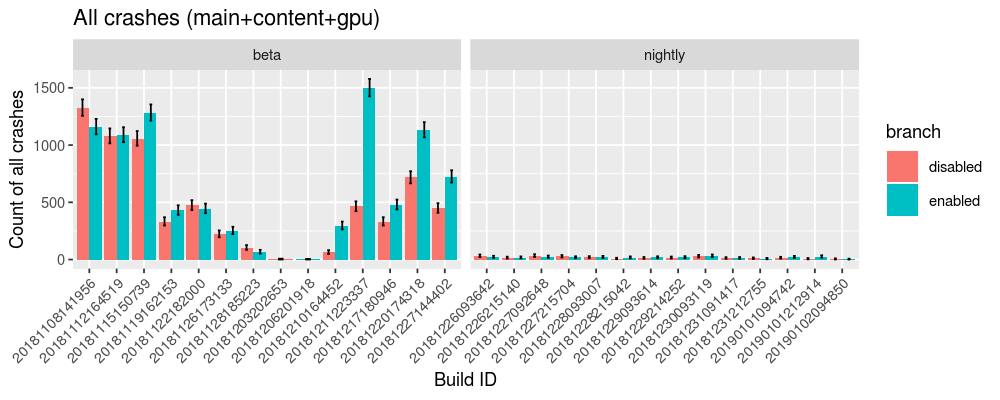

In [21]:
%r
crashes_per_build %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, total_crashes, fill=branch)) +
    facet_grid(~normalized_channel, space="free_x", scales="free_x", drop=TRUE) +
    geom_col(position=position_dodge()) +
    geom_errorbar(position=position_dodge(w=1), width=0.2, mapping=aes(ymin=ymin, ymax=ymax)) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    labs(x="Build ID", y="Count of all crashes", title="All crashes (main+content+gpu)")

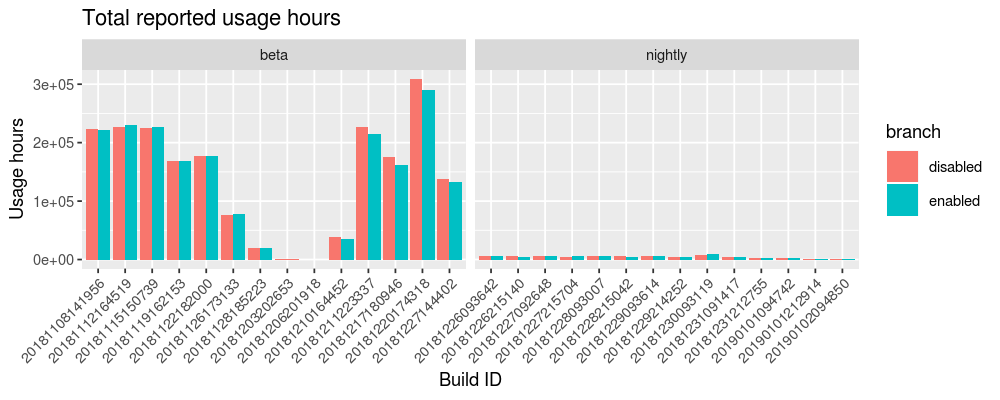

In [22]:
%r
crashes_per_build %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, usage_hours, fill=branch)) +
    facet_grid(~normalized_channel, space="free_x", scales="free_x", drop=TRUE) +
    geom_col(position=position_dodge()) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    labs(x="Build ID", y="Usage hours", title="Total reported usage hours")
    # coord_cartesian(ylim=c(0, 10000))

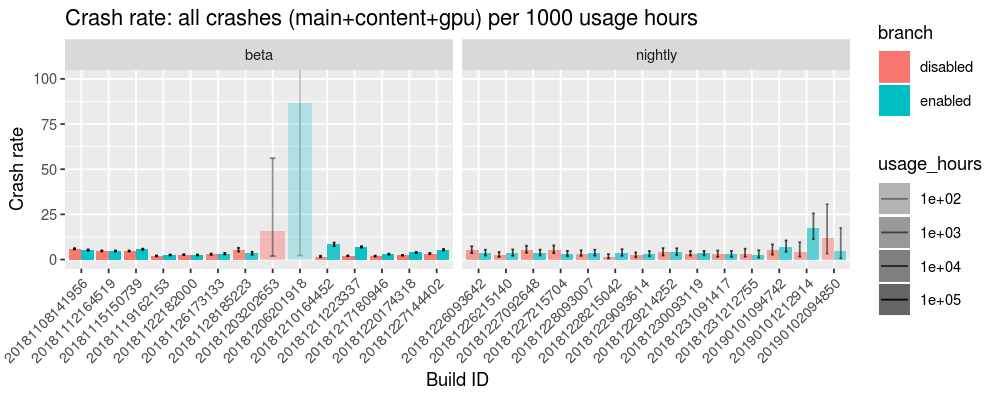

In [23]:
%r
crashes_per_build %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, total_crashes/usage_hours*1000, fill=branch, alpha=usage_hours)) +
    facet_grid(~normalized_channel, space="free_x", scales="free_x", drop=TRUE) +
    geom_col(position=position_dodge()) +
    geom_errorbar(position=position_dodge(w=1), width=0.2, mapping=aes(ymin=ymin/usage_hours*1000, ymax=ymax/usage_hours*1000)) +
    scale_alpha_continuous(trans="log10", range=c(0.25, 1.0)) +
    coord_cartesian(ylim=c(0, 0.1)*1000) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    labs(x="Build ID", y="Crash rate", title="Crash rate: all crashes (main+content+gpu) per 1000 usage hours")

## Crash detail

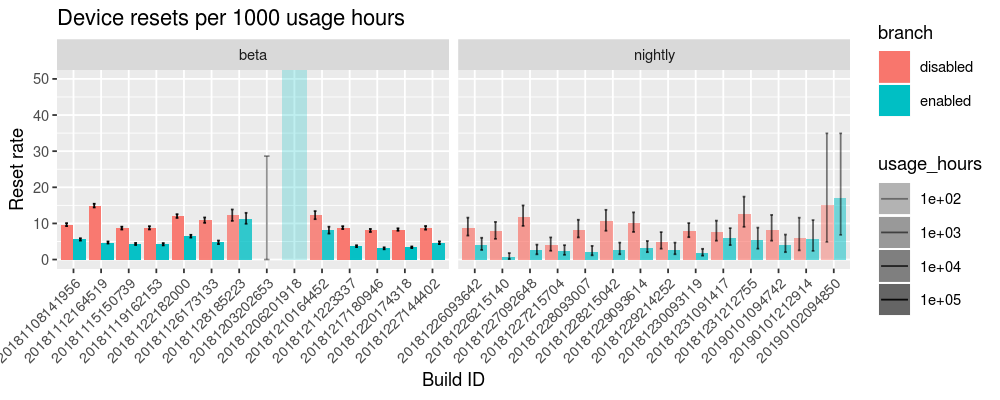

In [25]:
%r
crashes_per_build %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, device_reset_reason_total/usage_hours*1000, fill=branch, alpha=usage_hours)) +
    facet_grid(~normalized_channel, space="free_x", scales="free_x", drop=TRUE) +
    geom_col(position=position_dodge()) +
    geom_errorbar(
      mapping=aes(
        ymin=qchisq(0.025, 2*device_reset_reason_total)/2/usage_hours*1000,
        ymax=qchisq(0.975, 2*(device_reset_reason_total+1))/2/usage_hours*1000
      ),
      width=0.2,
      position=position_dodge(width=1)
    ) +
    scale_alpha_continuous(trans="log10", range=c(0.25, 1)) +
    coord_cartesian(ylim=c(0, 0.05)*1000) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    labs(title="Device resets per 1000 usage hours", x="Build ID", y="Reset rate")

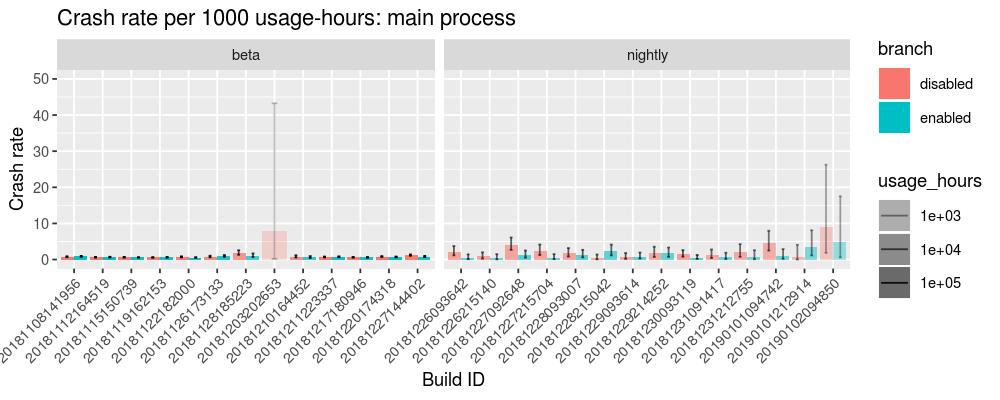

In [26]:
%r
crashes_per_build_per_process %>%
  inner_join(display_builds) %>%
  filter(process == "main") %>%
  ggplot(aes(app_build_id, total_crashes/usage_hours*1000, fill=branch, alpha=usage_hours)) +
    facet_grid(~normalized_channel, space="free_x", scales="free_x", drop=TRUE) +
    geom_col(position=position_dodge()) +
    geom_errorbar(position=position_dodge(w=1), width=0.2, mapping=aes(ymin=ymin/usage_hours*1000, ymax=ymax/usage_hours*1000)) +
    scale_alpha_continuous(trans="log10", range=c(0.25, 1)) +
    coord_cartesian(ylim=c(0, 0.05)*1000) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    labs(x="Build ID", y="Crash rate", title="Crash rate per 1000 usage-hours: main process")

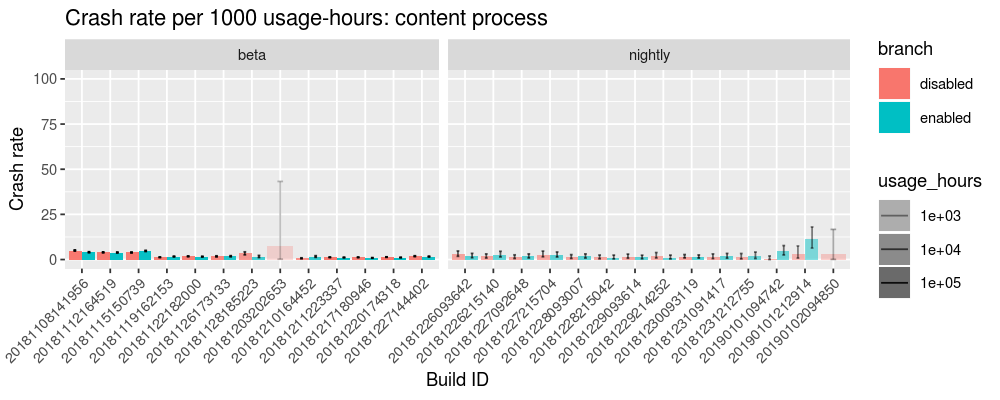

In [27]:
%r
crashes_per_build_per_process %>%
  inner_join(display_builds) %>%
  filter(process == "content") %>%
  ggplot(aes(app_build_id, total_crashes/usage_hours*1000, fill=branch, alpha=usage_hours)) +
    facet_grid(~normalized_channel, space="free_x", scales="free_x", drop=TRUE) +
    geom_col(position=position_dodge()) +
    geom_errorbar(position=position_dodge(w=1), width=0.2, mapping=aes(ymin=ymin/usage_hours*1000, ymax=ymax/usage_hours*1000)) +
    scale_alpha_continuous(trans="log10", range=c(0.25, 1)) +
    coord_cartesian(ylim=c(0, 0.1)*1000) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    labs(x="Build ID", y="Crash rate", title="Crash rate per 1000 usage-hours: content process")

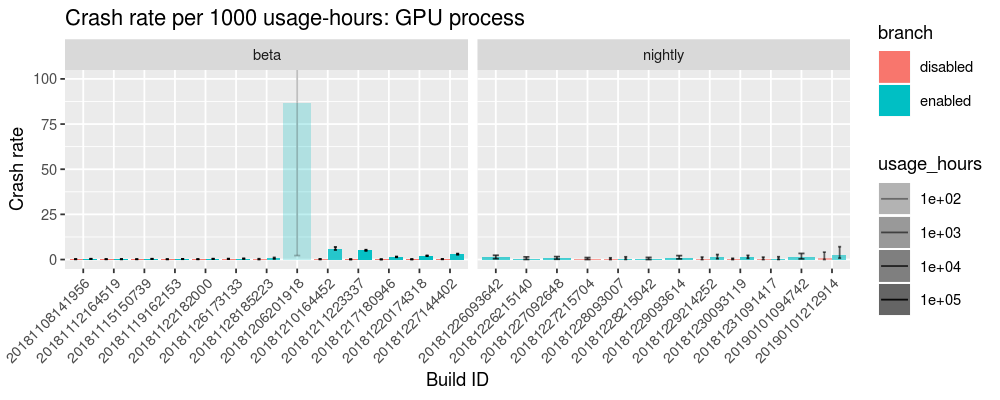

In [28]:
%r
crashes_per_build_per_process %>%
  inner_join(display_builds) %>%
  filter(process == "gpu") %>%
  ggplot(aes(app_build_id, total_crashes/usage_hours*1000, fill=branch, alpha=usage_hours)) +
    facet_grid(~normalized_channel, space="free_x", scales="free_x", drop=TRUE) +
    geom_col(position=position_dodge()) +
    geom_errorbar(position=position_dodge(w=1), width=0.2, mapping=aes(ymin=ymin/usage_hours*1000, ymax=ymax/usage_hours*1000)) +
    scale_alpha_continuous(trans="log10", range=c(0.25, 1)) +
    coord_cartesian(ylim=c(0, 0.1)*1000) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    labs(x="Build ID", y="Crash rate", title="Crash rate per 1000 usage-hours: GPU process")

## Performance metrics

Error bars are 95% confidence intervals for the central parameter of the per-user aggregate assuming a log-normal population distribution.

In [30]:
%r
metrics = tbl(sc, "global_temp.webrender_metrics")
per_user_build = metrics %>%
  select(app_build_id, normalized_channel, branch, client_id, ends_with("_count"), ends_with("_sum")) %>%
  select(-starts_with("device_reset_reason")) %>%
  group_by(app_build_id, normalized_channel, branch, client_id) %>%
  summarize_all(sum) %>%
  collect %>%
  gather("metric", "value", ends_with("_count"), ends_with("_sum")) %>%
  separate(metric, c("metric", "agg"), sep="_(?!.*_)") %>%
  spread(agg, value) %>%
  mutate(mean=sum/count)

In [31]:
%r
perf_medians = per_user_build %>%
  group_by(app_build_id, normalized_channel, branch, metric) %>%
  summarize(
    user_median=median(mean, na.rm=TRUE),
    log_sd=sd(log10(mean+1), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

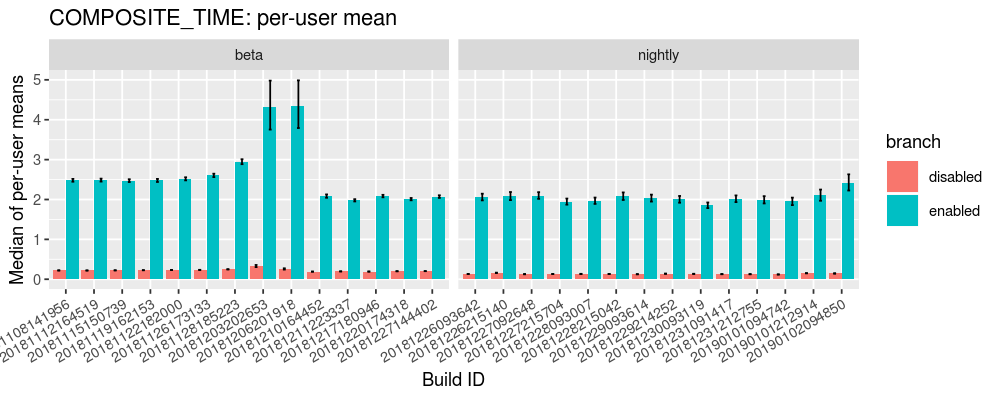

In [32]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="composite_time") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    coord_cartesian(ylim=c(0, 5)) +
    labs(title="COMPOSITE_TIME: per-user mean", x="Build ID", y="Median of per-user means")

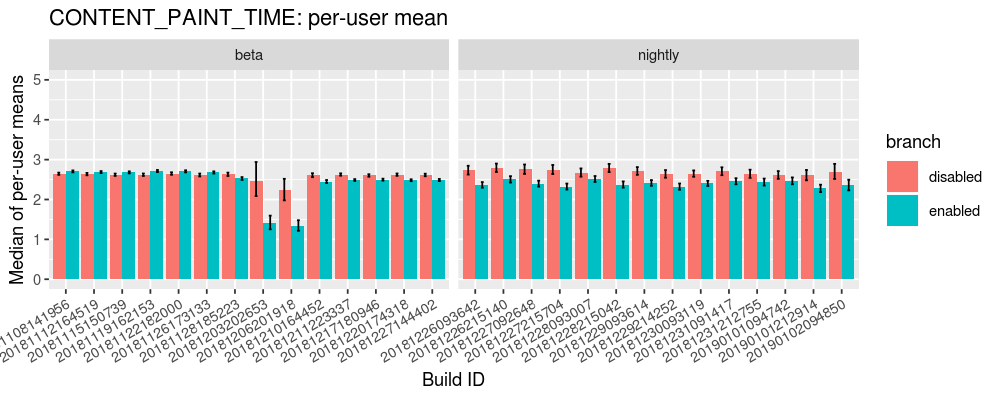

In [33]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="content_paint_time") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    coord_cartesian(ylim=c(0, 5)) +
    labs(title="CONTENT_PAINT_TIME: per-user mean", x="Build ID", y="Median of per-user means")

In [34]:
%r
paint_time_quantiles = tbl(sc, "global_temp.wr_paint_time_quantiles") %>%
  collect %>%
  group_by(app_build_id, normalized_channel, branch, quantile) %>%
  summarize(
    user_median=median(value, na.rm=TRUE),
    log_sd=sd(log10(value+1), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

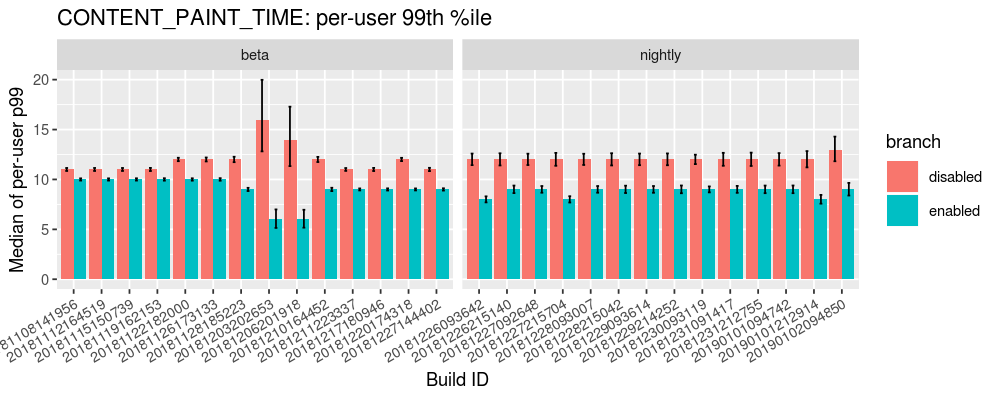

In [35]:
%r
paint_time_quantiles %>%
  inner_join(display_builds) %>%
  filter(quantile == 0.99) %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_PAINT_TIME: per-user 99th %ile", x="Build ID", y="Median of per-user p99")

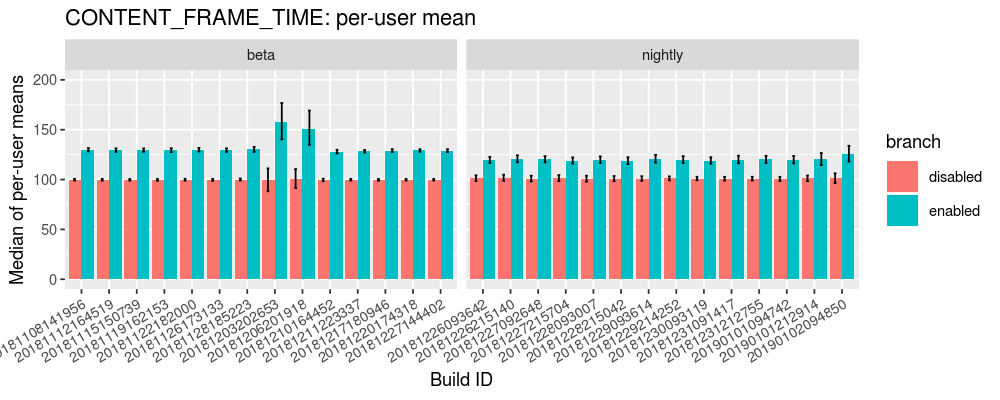

In [36]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="content_frame_time") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    coord_cartesian(ylim=c(0, 200)) +
    labs(title="CONTENT_FRAME_TIME: per-user mean", x="Build ID", y="Median of per-user means")

In [37]:
%r
slow_content_frame_time = tbl(sc, "global_temp.wr_slow_content_frame_time") %>% collect

In [38]:
%r
slow_content_frame_boot = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) median(data[x], na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

In [39]:
%r
# Thresholded slow events
# "composite_time", "content_paint_time", "content_full_paint_time"
slow_composite_time_summary = tbl(sc, "global_temp.wr_slow_composite_time") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

In [40]:
%r
slow_content_paint_time_summary = tbl(sc, "global_temp.wr_slow_content_paint_time") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

In [41]:
%r
slow_content_full_paint_time_summary = tbl(sc, "global_temp.wr_slow_content_full_paint_time") %>%
  collect %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

[1] "All values of t are equal to 0.00561206594177482 \n Cannot calculate confidence intervals"

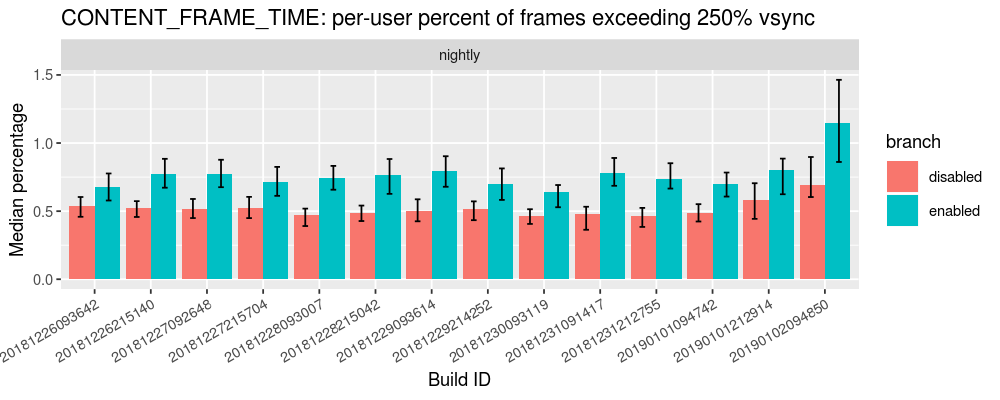

In [42]:
%r
slow_content_frame_time_summary %>%
  inner_join(display_builds) %>%
  filter(normalized_channel == 'nightly') %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 250% vsync", x="Build ID", y="Median percentage")

In [43]:
%r
slow_content_frame_boot_p90 = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) quantile(data[x], 0.9, na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary_p90 = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot_p90(.))

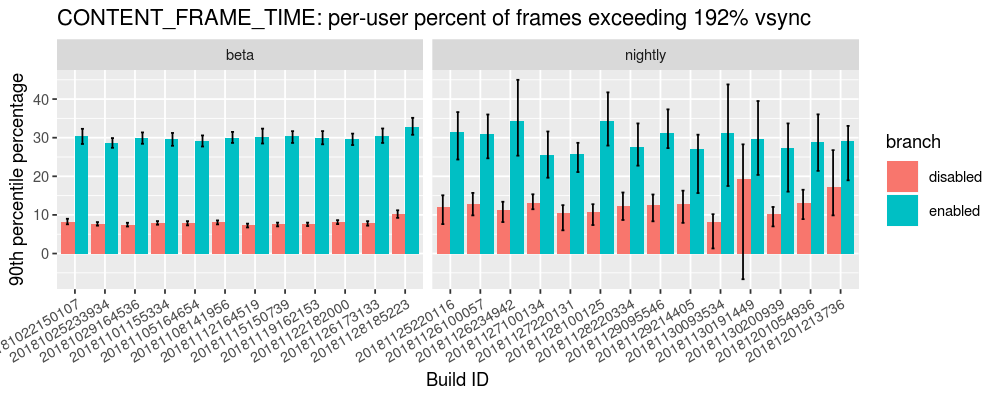

In [44]:
%r
slow_content_frame_time_summary_p90 %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", x="Build ID", y="90th percentile percentage")

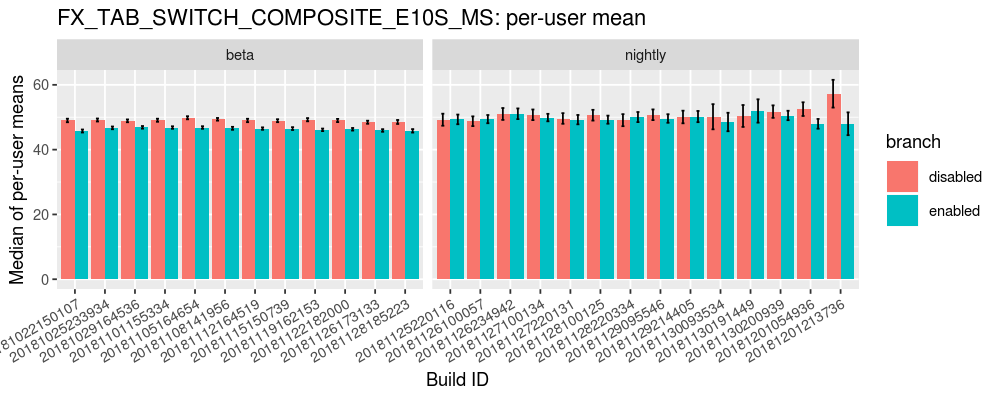

In [45]:
%r
perf_medians %>%
  inner_join(display_builds) %>%
  filter(metric=="tab_switch_composite") %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="FX_TAB_SWITCH_COMPOSITE_E10S_MS: per-user mean", x="Build ID", y="Median of per-user means")

## Engagement metrics

In [47]:
%r
engagement = metrics %>%
  group_by(client_id, app_build_id, normalized_channel, branch) %>%
  summarize(
    hours=sum(subsession_length)/3600,
    active_hours=sum(active_ticks)*5/3600,
    uris=sum(total_uris)
  ) %>%
  mutate(
    intensity=active_hours/hours,
    uris_per_active_hour=uris/active_hours
  ) %>%
  collect

In [48]:
%r
uri_summary = engagement %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  summarize(
    user_median=median(uris_per_active_hour, na.rm=TRUE),
    log_sd=sd(log10(uris_per_active_hour), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

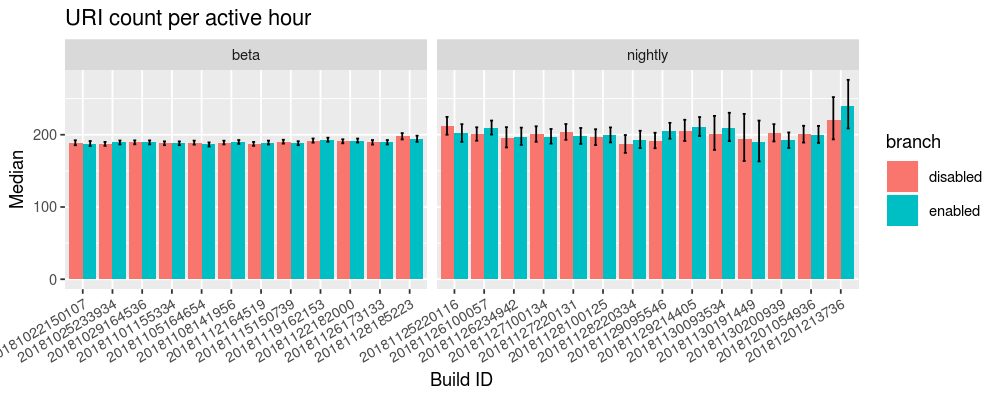

In [49]:
%r
uri_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, user_median, ymin=10**log_ymin, ymax=10**log_ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(x="Build ID", y="Median", title="URI count per active hour")

In [50]:
%r
intensity_boot = function(df) {
  ci = boot(df$intensity, function(data, x) median(data[x], na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

intensity_summary = engagement %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(intensity_boot(.))

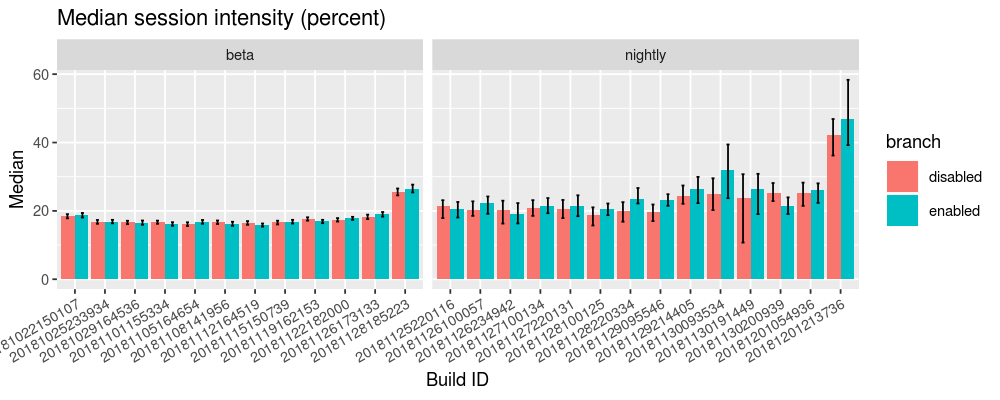

In [51]:
%r
intensity_summary %>%
  inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(x="Build ID", y="Median", title="Median session intensity (percent)")

In [52]:
%r
head(intensity_summary)

# A tibble: 6 x 6
# Groups: normalized_channel, app_build_id, branch [6]
 normalized_channel app_build_id branch ymin y ymax
 
1 beta 20181022150107 disabled 17.8 18.4 19.0
2 beta 20181022150107 enabled 18.1 18.7 19.4
3 beta 20181025143507 disabled -18.7 32.3 42.1
4 beta 20181025143507 enabled 60.7 92.9 147. 
5 beta 20181025233934 disabled 16.2 16.8 17.4
6 beta 20181025233934 enabled 16.4 16.9 17.4

# Enrollment

In [54]:
events = spark.table("events")

my_events = (
  events
  .filter(events.submission_date_s3 > "20180923")
  .filter(events.event_category == "normandy")
  .filter(events.event_string_value.isin(EXPERIMENT_ID, EXPERIMENT_ID_2))
  .filter((events.normalized_channel == "nightly") | (events.normalized_channel == "beta"))
  .withColumn("branch", events.event_map_values.getItem("branch"))
  .withColumn("slug", events.event_string_value)
  .cache()
)

enrollments = (
  my_events
  .filter(my_events.event_method == "enroll")
  .groupBy(my_events.slug, my_events.normalized_channel, my_events.client_id, my_events.branch)
  .agg(f.min(my_events.submission_date_s3).alias("submission_date_s3"))
  .groupBy(my_events.slug, my_events.normalized_channel, my_events.branch, "submission_date_s3")
  .agg(f.count("*").alias("n"))
)
enrollments.createOrReplaceGlobalTempView("wr_enrollments")

unenrollments = (
  my_events
  .filter(my_events.event_method == "unenroll")
  .withColumn("reason", my_events.event_map_values.getItem("reason"))
  .groupBy(my_events.slug, my_events.normalized_channel, my_events.branch, my_events.submission_date_s3, "reason")
  .agg(f.count("*").alias("n"))
)
unenrollments.createOrReplaceGlobalTempView("wr_unenrollments")

In [55]:
%r
enrollment_summary = tbl(sc, "global_temp.wr_enrollments") %>% collect
unenrollment_summary = tbl(sc, "global_temp.wr_unenrollments") %>% collect

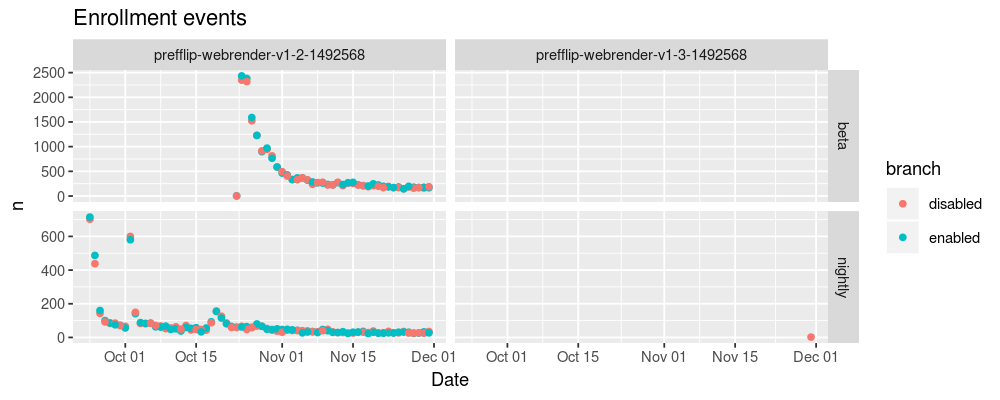

In [56]:
%r
ggplot(enrollment_summary, aes(as.Date(submission_date_s3, "%Y%m%d"), n, color=branch)) +
  facet_grid(normalized_channel~slug, scales="free_y") +
  geom_point() +
  labs(x="Date", title="Enrollment events")

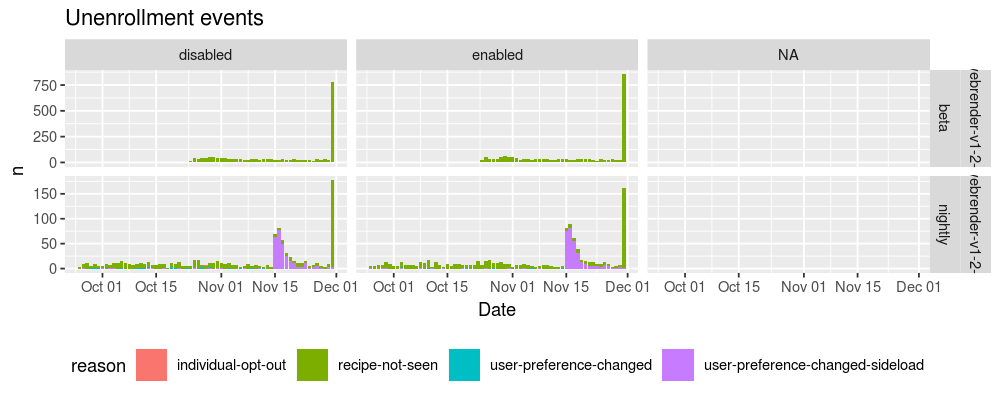

In [57]:
%r
ggplot(unenrollment_summary, aes(as.Date(submission_date_s3, "%Y%m%d"), n, fill=reason)) +
  facet_grid(slug+normalized_channel~branch, scales="free_y") +
  geom_col() +
  theme(legend.position="bottom") +
  labs(x="Date", title="Unenrollment events")

In [58]:
%r # Surviving users per day

users_by_build = metrics %>%
  distinct(experiment, app_build_id, normalized_channel, branch, client_id) %>%
  group_by(experiment, app_build_id, normalized_channel, branch) %>%
  summarize(n=n()) %>%
  collect

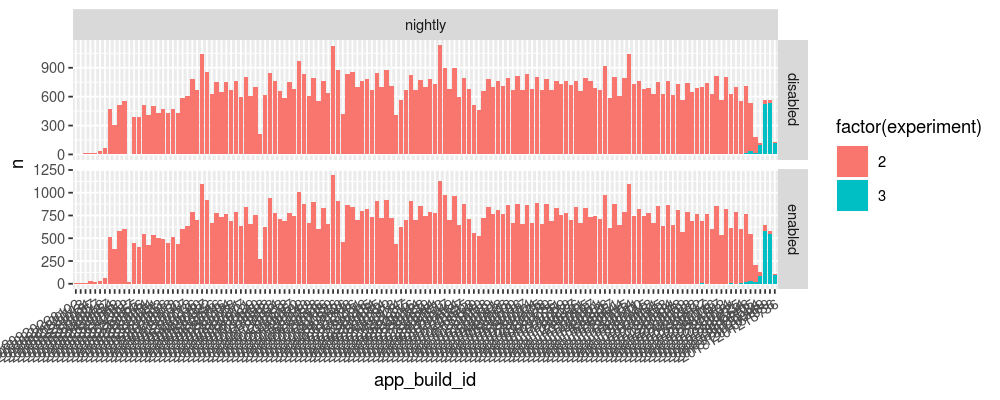

In [59]:
%r
users_by_build %>%
filter(normalized_channel == "nightly") %>%
  ggplot(aes(app_build_id, n, fill=factor(experiment))) +
    facet_grid(branch~normalized_channel, scales="free") +
    geom_col() +
    theme(axis.text.x=element_text(angle=30, hjust=1))

In [60]:
%r
perf_summary_for = function(channel) {
  last_build_id = crashes_per_build %>%
    filter(normalized_channel == channel) %>%
    select(app_build_id, branch, usage_hours) %>%
    spread(branch, usage_hours) %>%
    filter(enabled >= 1000, disabled >= 1000) %>%
    arrange(desc(app_build_id)) %>%
    head(1) %>%
    pull(app_build_id)

  summarize_perf = function(df) {
    mystat = function(data, indices) {
      sample = data[indices,]
      median(sample[sample$branch == "enabled",]$mean, na.rm=TRUE) / median(sample[sample$branch == "disabled",]$mean, na.rm=TRUE)
    }

    ci = df %>%
      boot(mystat, 200, strata=factor(df$branch)) %>%
      boot.ci(0.95, type="basic")
    data.frame(
      ymin=ci$basic[4],
      y=ci$t0,
      ymax=ci$basic[5]
    ) * 100
  }
  
  summarize_slow = function(df) {
    mystat = function(data, indices) {
      sample = data[indices,]
      median(sample[sample$branch == "enabled",]$fraction_exceeding, na.rm=TRUE) / median(sample[sample$branch == "disabled",]$fraction_exceeding, na.rm=TRUE)
    }

    ci = df %>%
      boot(mystat, 200, strata=factor(df$branch)) %>%
      boot.ci(0.95, type="basic")
    data.frame(
      ymin=ci$basic[4],
      y=ci$t0,
      ymax=ci$basic[5]
    ) * 100
  }

  perf_summary = per_user_build %>%
    filter(normalized_channel == channel, app_build_id == last_build_id, metric != "composite_time", metric != "content_frame_time") %>%
    filter(!is.na(mean)) %>%
    group_by(metric) %>%
    do(summarize_perf(.))
  
  slow_content_frame_time_comp = slow_content_frame_time %>%
    filter(normalized_channel == channel, app_build_id == last_build_id) %>%
    summarize_slow %>%
    mutate(metric="slow_content_frame_time")

  bind_rows(perf_summary, slow_content_frame_time_comp)
}

nightly_perf_summary = perf_summary_for("nightly")
beta_perf_summary = perf_summary_for("beta")

In [61]:
%r
outdb_path = tempfile()
outdb = DBI::dbConnect(RSQLite::SQLite(), dbname=outdb_path)
copy_to(outdb, crashes_per_build, temporary=FALSE)
copy_to(outdb, crashes_per_build_per_process, temporary=FALSE)
copy_to(outdb, perf_medians, temporary=FALSE)

copy_to(outdb, slow_content_frame_time_summary, temporary=FALSE)
copy_to(outdb, slow_content_paint_time_summary, temporary=FALSE)
copy_to(outdb, slow_content_full_paint_time_summary, temporary=FALSE)
copy_to(outdb, slow_composite_time_summary, temporary=FALSE)

copy_to(outdb, paint_time_quantiles, temporary=FALSE)

copy_to(outdb, intensity_summary, temporary=FALSE)
copy_to(outdb, uri_summary, temporary=FALSE)

copy_to(outdb, enrollment_summary, temporary=FALSE)
copy_to(outdb, unenrollment_summary, temporary=FALSE)
copy_to(outdb, users_by_build, temporary=FALSE)

copy_to(outdb, nightly_perf_summary, temporary=FALSE)
copy_to(outdb, beta_perf_summary, temporary=FALSE)

copy_to(outdb, data.frame(
    last_update=as.character(Sys.time())
  ), name="metadata", temporary=FALSE)
DBI::dbDisconnect(outdb)
file.copy(from=outdb_path, to=final_outdb_path, overwrite=TRUE)

[1] TRUE

In [62]:
%r
# Bootstrap for the ratio of performance metrics



